In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K

In [ ]:
train_df = pd.read_excel('/content/drive/My Drive/Files-Covid/train.xlsx')
test_df = pd.read_excel('/content/drive/My Drive/Files-Covid/test.xlsx')
valid_df = pd.read_excel('/content/drive/My Drive/Files-Covid/valid.xlsx')

In [ ]:
labels = ['Covid']

def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 200, target_h =200):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 200, target_h = 200):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMG_DIR, 
        x_col="Source", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator
    
IMG_DIR = "/content/drive/My Drive/Files-Covid/IMG_DIR/"
train_generator_192 = get_train_generator(train_df, IMG_DIR, "Source", labels,target_w = 192, target_h = 192)
valid_generator_192, test_generator_192= get_test_and_valid_generator(valid_df, test_df, train_df, IMG_DIR, "Source", labels, target_w = 192, target_h = 192)

getting train generator...
Found 425 validated image filenames.
getting train and valid generators...
Found 425 validated image filenames.
Found 118 validated image filenames.
Found 203 validated image filenames.


In [ ]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Tensor): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += -K.mean(pos_weights[i]*y_true[:,i]*K.log(y_pred[:,i]+epsilon) + neg_weights[i]*(1-y_true[:,i])*K.log(1-y_pred[:,i]+epsilon)) 
        return loss
    return weighted_loss

def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels,axis=0)/N
    negative_frequencies = np.ones_like(positive_frequencies) - positive_frequencies

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

freq_pos, freq_neg = compute_class_freqs(train_generator_192.labels)
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

In [ ]:
# Load model into KerasLayer
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
module = hub.KerasLayer(model_url)

In [ ]:
# Add new head to the BiT model

class MyBiTModel(tf.keras.Model):
  """BiT with a new head."""

  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.head = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros',activation=tf.keras.activations.sigmoid, kernel_regularizer=tf.keras.regularizers.l2(0.1))
    self.bit_model = module
  
  def call(self, images):
    # No need to cut head off since we are using feature extractor model
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

model = MyBiTModel(num_classes=1, module=module)

In [ ]:
STEPS_PER_EPOCH = 10
BATCH_SIZE = 512
# Define optimiser and loss
SCHEDULE_LENGTH = 10000
SCHEDULE_BOUNDARIES = [3000, 6000, 9000]
lr = 0.003 * BATCH_SIZE / 512 
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE
# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = get_weighted_loss(pos_weights,neg_weights)

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
# Fine-tune model
history = model.fit(
    train_generator_192,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs= int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
    validation_data=test_generator_192,  # here we are only using .this data to evaluate our performance
)

Epoch 1/1000
10/10 [==============================] - 4s 357ms/step - loss: 0.5800 - accuracy: 0.6250 - val_loss: 0.4090 - val_accuracy: 0.7635
Epoch 2/1000
10/10 [==============================] - 2s 208ms/step - loss: 0.5516 - accuracy: 0.7375 - val_loss: 1.3056 - val_accuracy: 0.6847
Epoch 3/1000
10/10 [==============================] - 2s 243ms/step - loss: 1.1936 - accuracy: 0.6849 - val_loss: 0.5799 - val_accuracy: 0.7438
Epoch 4/1000
10/10 [==============================] - 2s 198ms/step - loss: 1.4089 - accuracy: 0.6986 - val_loss: 0.6058 - val_accuracy: 0.7586
Epoch 5/1000
10/10 [==============================] - 2s 225ms/step - loss: 0.7194 - accuracy: 0.8000 - val_loss: 0.9809 - val_accuracy: 0.6798
Epoch 6/1000
10/10 [==============================] - 2s 214ms/step - loss: 2.6588 - accuracy: 0.5625 - val_loss: 0.9705 - val_accuracy: 0.6946
Epoch 7/1000
10/10 [==============================] - 2s 213ms/step - loss: 0.9968 - accuracy: 0.7000 - val_loss: 1.2181 - val_accuracy:

In [ ]:
model.summary()

Model: "my_bi_t_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  2049      
_________________________________________________________________
keras_layer (KerasLayer)     multiple                  23500352  
Total params: 23,502,401
Trainable params: 2,049
Non-trainable params: 23,500,352
_________________________________________________________________


In [ ]:
model.evaluate(test_generator_192)

26/26 [==============================] - 1s 53ms/step - loss: 0.3122 - accuracy: 0.7635


[0.31219911575317383, 0.7635468244552612]

In [ ]:
predict = model.predict(test_generator_192)

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

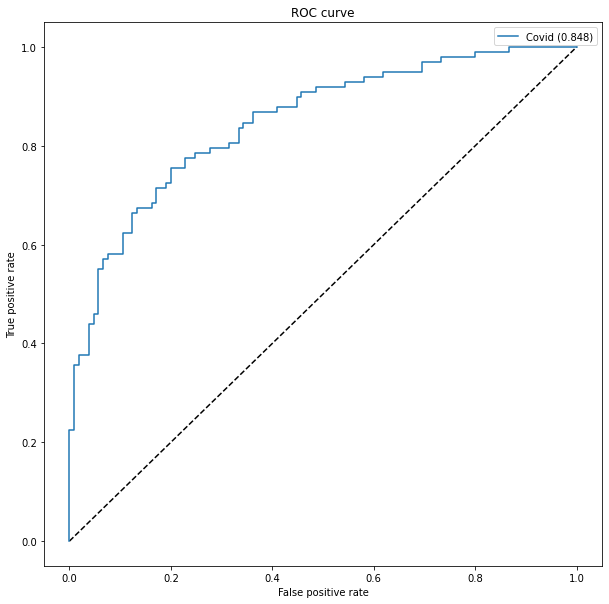

In [ ]:
auc_rocs = get_roc_curve(labels, predict, test_generator_192)

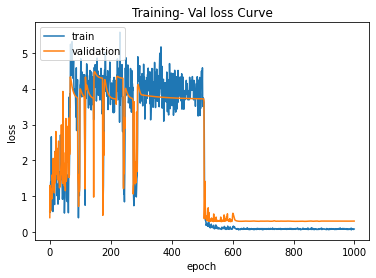

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training- Val loss Curve")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

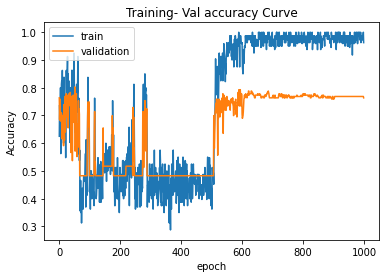

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel("Accuracy")
plt.xlabel("epoch")
plt.title("Training- Val accuracy Curve")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity

In [ ]:
def get_mean_std_per_batch(image_path, df, H=200, W=200):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Source"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std
def load_image(img, image_dir, df, preprocess=True, H=200, W=200):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x

def grad_cam(input_model, image, cls, layer_name, H=200, W=200):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam


def compute_gradcam(model, img, image_dir, df, labels, selected_labels,
                    layer_name='conv5_block3_2_bn'):
    preprocessed_input = load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)

    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')

    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            plt.subplot(151 + j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(load_image(img, image_dir, df, preprocess=False),
                       cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1

In [ ]:
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])

In [ ]:
class_labes = ['Covid']
pred_labels = ['Covid_pred']

In [ ]:
def true_positives(y, pred, th=0.4):
    """
    Count true positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        TP (int): true positives
    """
    TP = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    # compute TP
    TP = np.sum((y == 1) & (thresholded_preds == 1))
    
    return TP

def true_negatives(y, pred, th=0.4):
    """
    Count true negatives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        TN (int): true negatives
    """
    TN = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # compute TN
    TN =  np.sum((y == 0) & (thresholded_preds == 0))
    
    ### END CODE HERE ###
    
    return TN

def false_positives(y, pred, th=0.4):
    """
    Count false positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        FP (int): false positives
    """
    FP = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # compute FP
    FP =  np.sum((y == 0) & (thresholded_preds == 1))
    
    ### END CODE HERE ###
    
    return FP

def false_negatives(y, pred, th=0.4):
    """
    Count false positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        FN (int): false negatives
    """
    FN = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # compute FN
    FN =  np.sum((y == 1) & (thresholded_preds == 0))
    
    ### END CODE HERE ###
    
    return FN

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)


def get_true_pos(y, pred, th=0.4):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 1))


def get_true_neg(y, pred, th=0.4):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 0))


def get_false_neg(y, pred, th=0.4):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 1))


def get_false_pos(y, pred, th=0.4):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 0))


def get_performance_metrics(y, pred, class_labels, tp=get_true_pos,
                            tn=get_true_neg, fp=get_false_pos,
                            fn=get_false_neg,
                            acc=None, prevalence=None, spec=None,
                            sens=None, ppv=None, npv=None, auc=None, f1=None,
                            thresholds=[]):
    if len(thresholds) != len(class_labels):
        thresholds = [.5] * len(class_labels)

    columns = ["", "TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
               "Sensitivity",
               "Specificity", "PPV", "NPV", "AUC", "F1", "Threshold"]
    df = pd.DataFrame(columns=columns)
    for i in range(len(class_labels)):
        df.loc[i] = [""] + [0] * (len(columns) - 1)
        df.loc[i][0] = class_labels[i]
        df.loc[i][1] = round(tp(y[:, i], pred[:, i]),
                             3) if tp != None else "Not Defined"
        df.loc[i][2] = round(tn(y[:, i], pred[:, i]),
                             3) if tn != None else "Not Defined"
        df.loc[i][3] = round(fp(y[:, i], pred[:, i]),
                             3) if fp != None else "Not Defined"
        df.loc[i][4] = round(fn(y[:, i], pred[:, i]),
                             3) if fn != None else "Not Defined"
        df.loc[i][5] = round(acc(y[:, i], pred[:, i], thresholds[i]),
                             3) if acc != None else "Not Defined"
        df.loc[i][6] = round(prevalence(y[:, i]),
                             3) if prevalence != None else "Not Defined"
        df.loc[i][7] = round(sens(y[:, i], pred[:, i], thresholds[i]),
                             3) if sens != None else "Not Defined"
        df.loc[i][8] = round(spec(y[:, i], pred[:, i], thresholds[i]),
                             3) if spec != None else "Not Defined"
        df.loc[i][9] = round(ppv(y[:, i], pred[:, i], thresholds[i]),
                             3) if ppv != None else "Not Defined"
        df.loc[i][10] = round(npv(y[:, i], pred[:, i], thresholds[i]),
                              3) if npv != None else "Not Defined"
        df.loc[i][11] = round(auc(y[:, i], pred[:, i]),
                              3) if auc != None else "Not Defined"
        df.loc[i][12] = round(f1(y[:, i], pred[:, i] > thresholds[i]),
                              3) if f1 != None else "Not Defined"
        df.loc[i][13] = round(thresholds[i], 3)

    df = df.set_index("")
    return df


def print_confidence_intervals(class_labels, statistics):
    df = pd.DataFrame(columns=["Mean AUC (CI 5%-95%)"])
    for i in range(len(class_labels)):
        mean = statistics.mean(axis=1)[i]
        max_ = np.quantile(statistics, .95, axis=1)[i]
        min_ = np.quantile(statistics, .05, axis=1)[i]
        df.loc[class_labels[i]] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
    return df


def get_curve(gt, pred, target_names, curve='roc'):
    for i in range(len(target_names)):
        if curve == 'roc':
            curve_function = roc_curve
            auc_roc = roc_auc_score(gt[:, i], pred[:, i])
            label = target_names[i] + " AUC: %.3f " % auc_roc
            xlabel = "False positive rate"
            ylabel = "True positive rate"
            a, b, _ = curve_function(gt[:, i], pred[:, i])
            plt.figure(1, figsize=(7, 7))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(a, b, label=label)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)

            plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        elif curve == 'prc':
            precision, recall, _ = precision_recall_curve(gt[:, i], pred[:, i])
            average_precision = average_precision_score(gt[:, i], pred[:, i])
            label = target_names[i] + " Avg.: %.3f " % average_precision
            plt.figure(1, figsize=(7, 7))
            plt.step(recall, precision, where='post', label=label)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.ylim([0.0, 1.05])
            plt.xlim([0.0, 1.0])
            plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)

In [ ]:
df1 = pd.DataFrame(test_generator_192.labels, columns= ['Covid'])

In [ ]:
df2 = pd.DataFrame(predict,columns=['Covid_pred'])

In [ ]:
df = [df1 , df2]

result = pd.concat(df,axis=1)

In [ ]:
y = result[class_labes].values
pred = result[pred_labels].values

In [ ]:
result[np.concatenate([class_labes, pred_labels])].head()

,Covid,Covid_pred
0,1,0.993587
1,1,0.018506
2,1,0.985685
3,1,0.261371
4,1,0.970502


In [ ]:
get_performance_metrics(y, pred, class_labes)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Covid,76,81,24,22,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5


In [ ]:
def get_accuracy(y, pred, th=0.5):
    """
    Compute accuracy of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        accuracy (float): accuracy of predictions at threshold
    """
    accuracy = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TP, FP, TN, FN using our previously defined functions
    TP = true_positives(y,pred,th=0.5)
    FP = false_positives(y,pred, th=0.5)
    TN = true_negatives(y, pred, th=0.5)
    FN = false_negatives(y, pred, th=0.5)

    # Compute accuracy using TP, FP, TN, FN
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    
    ### END CODE HERE ###
    
    return accuracy

In [ ]:
get_performance_metrics(y, pred, class_labes, acc=get_accuracy)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Covid,76,81,24,22,0.764,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5


In [ ]:
get_accuracy(result["Covid"].values, np.zeros(len(result)))

0.5172413793103449

In [ ]:
def get_prevalence(y):
    """
    Compute accuracy of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
    Returns:
        prevalence (float): prevalence of positive cases
    """
    prevalence = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    prevalence = np.mean(y)
    
    ### END CODE HERE ###
    
    return prevalence

In [ ]:
def get_sensitivity(y, pred, th=0.5):
    """
    Compute sensitivity of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        sensitivity (float): probability that our test outputs positive given that the case is actually positive
    """
    sensitivity = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TP and FN using our previously defined functions
    TP = true_positives(y,pred, th =0.5)
    FN = false_negatives(y,pred, th=0.5)

    # use TP and FN to compute sensitivity
    sensitivity = TP / (TP+FN)
    
    ### END CODE HERE ###
    
    return sensitivity

def get_specificity(y, pred, th=0.5):
    """
    Compute specificity of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        specificity (float): probability that the test outputs negative given that the case is actually negative
    """
    specificity = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TN and FP using our previously defined functions
    TN = true_negatives(y,pred,th=0.5)
    FP = false_positives(y,pred, th=0.5)
    
    # use TN and FP to compute specificity 
    specificity = TN / (TN+FP)
    
    ### END CODE HERE ###
    
    return specificity

In [ ]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_ppv(y, pred, th=0.5):
    """
    Compute PPV of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        PPV (float): positive predictive value of predictions at threshold
    """
    PPV = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TP and FP using our previously defined functions
    TP = true_positives(y,pred,th=0.5)
    FP = false_positives(y,pred, th =0.5)

    # use TP and FP to compute PPV
    PPV = TP / (TP+FP)
    
    ### END CODE HERE ###
    
    return PPV

def get_npv(y, pred, th=0.5):
    """
    Compute NPV of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        NPV (float): negative predictive value of predictions at threshold
    """
    NPV = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TN and FN using our previously defined functions
    TN = true_negatives(y,pred,th=0.5)
    FN = false_negatives(y,pred,th=0.5)

    # use TN and FN to compute NPV
    NPV = TN / (FN+TN)
    
    ### END CODE HERE ###
    
    return NPV

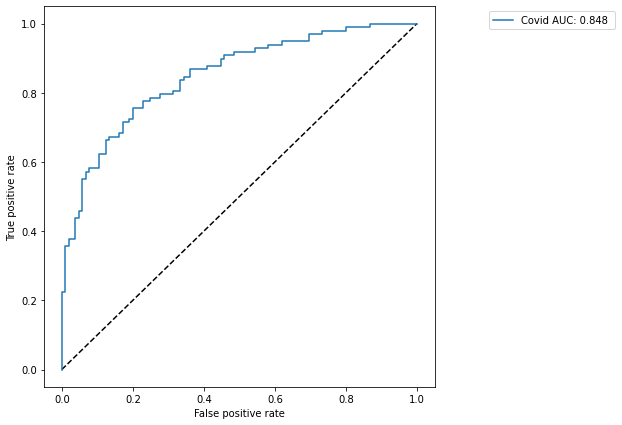

In [ ]:
get_curve(y, pred, class_labes)

In [ ]:
from sklearn.metrics import roc_auc_score
get_performance_metrics(y, pred, class_labes, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Covid,76,81,24,22,0.764,0.483,0.694,0.829,0.791,0.744,0.848,Not Defined,0.5


In [ ]:
def bootstrap_auc(y, pred, classes, bootstraps = 100, fold_size = 1000):
    statistics = np.zeros((len(classes), bootstraps))

    for c in range(len(classes)):
        df = pd.DataFrame(columns=['y', 'pred'])
        df.loc[:, 'y'] = y[:, c]
        df.loc[:, 'pred'] = pred[:, c]
        # get positive examples for stratified sampling
        df_pos = df[df.y == 1]
        df_neg = df[df.y == 0]
        prevalence = len(df_pos) / len(df)
        for i in range(bootstraps):
            # stratified sampling of positive and negative examples
            pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
            neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

            y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
            pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
            score = roc_auc_score(y_sample, pred_sample)
            statistics[c][i] = score
    return statistics

statistics = bootstrap_auc(y, pred, class_labes)

In [ ]:
print_confidence_intervals(class_labes, statistics)

,Mean AUC (CI 5%-95%)
Covid,0.85 (0.83-0.87)


In [ ]:
from sklearn.metrics import f1_score
get_performance_metrics(y, pred, class_labes, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Covid,76,81,24,22,0.764,0.483,0.694,0.829,0.791,0.744,0.848,0.739,0.5


In [ ]:
from sklearn.calibration import calibration_curve
def plot_calibration_curve(y, pred):
    plt.figure(figsize=(20, 20))
    for i in range(len(class_labes)):
        plt.subplot(4, 4, i + 1)
        fraction_of_positives, mean_predicted_value = calibration_curve(y[:,i], pred[:,i], n_bins=20)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(mean_predicted_value, fraction_of_positives, marker='.')
        plt.xlabel("Predicted Value")
        plt.ylabel("Fraction of Positives")
        plt.title(class_labes[i])
    plt.tight_layout()
    plt.show()

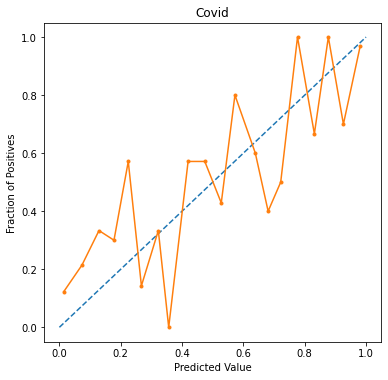

In [ ]:
plot_calibration_curve(y, pred)